In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from IPython.display import display, Markdown

np.random.seed(42)
sns.set(style="whitegrid", palette="pastel")

# Parámetros globales
HORAS_ANNO = 8760
LAMBDA = 5    # clientes/hora
MU = 6        # servicios/hora

In [ ]:
def simulacion_peluqueria(capacidad=5, T=HORAS_ANNO):
    t = 0.0
    proximo_arribo = np.random.exponential(1/LAMBDA)
    proxima_partida = float('inf')
    cola = []
    n = 0
    rechazados = 0
    clientes_totales = 0
    tiempos_espera = []
    
    acumulado_n = acumulado_q = 0.0
    tiempo_anterior = 0.0
    
    while True:
        evento_tiempo = min(proximo_arribo, proxima_partida)
        if evento_tiempo > T: break
        
        delta_t = evento_tiempo - tiempo_anterior
        acumulado_n += delta_t * n
        acumulado_q += delta_t * max(n-1, 0)
        tiempo_anterior = evento_tiempo
        
        if proximo_arribo < proxima_partida:
            # Evento de arribo
            if n < capacidad:
                n += 1
                clientes_totales += 1
                if n == 1:
                    servicio = np.random.exponential(1/MU)
                    proxima_partida = evento_tiempo + servicio
                    tiempos_espera.append(0.0)
                else:
                    cola.append(evento_tiempo)
                proximo_arribo += np.random.exponential(1/LAMBDA)
            else:
                rechazados += 1
                proximo_arribo += np.random.exponential(1/LAMBDA)
        else:
            # Evento de partida
            n -= 1
            if n >= 1:
                arribo_cliente = cola.pop(0)
                servicio = np.random.exponential(1/MU)
                proxima_partida = evento_tiempo + servicio
                tiempos_espera.append(evento_tiempo - arribo_cliente)
            else:
                proxima_partida = float('inf')
    
    return {
        'L': acumulado_n / tiempo_anterior,
        'Lq': acumulado_q / tiempo_anterior,
        'P_rechazo': rechazados / (rechazados + clientes_totales),
        'tiempos_espera': np.array(tiempos_espera)
    }

In [53]:
def mostrar_resultados(resultados):
    display(Markdown("### 📊 Resultados Principales"))
    display(Markdown(f"- **Clientes promedio en sistema:** {resultados['L']:.2f}"))
    display(Markdown(f"- **Clientes promedio en cola:** {resultados['Lq']:.2f}"))
    display(Markdown(f"- **Probabilidad de rechazo:** {resultados['P_rechazo']:.2%}"))
    
    esperas = resultados['tiempos_espera']
    display(Markdown(f"- **Tiempo espera promedio:** {np.mean(esperas)*60:.1f} minutos"))
    display(Markdown(f"- **Máxima espera:** {np.max(esperas)*60:.1f} minutos"))
    display(Markdown(f"- **% esperas > 45 min:** {np.mean(esperas > 0.75):.2%}"))

# Ejecutar simulación
resultados_base = simulacion_peluqueria()
mostrar_resultados(resultados_base)

### 📊 Resultados Principales

- **Clientes promedio en sistema:** 1.97

- **Clientes promedio en cola:** 1.22

- **Probabilidad de rechazo:** 10.00%

- **Tiempo espera promedio:** 16.3 minutos

- **Máxima espera:** 141.2 minutos

- **% esperas > 45 min:** 8.86%

### 🧪 Prueba de Hipótesis: 5 vs 6 Sillas

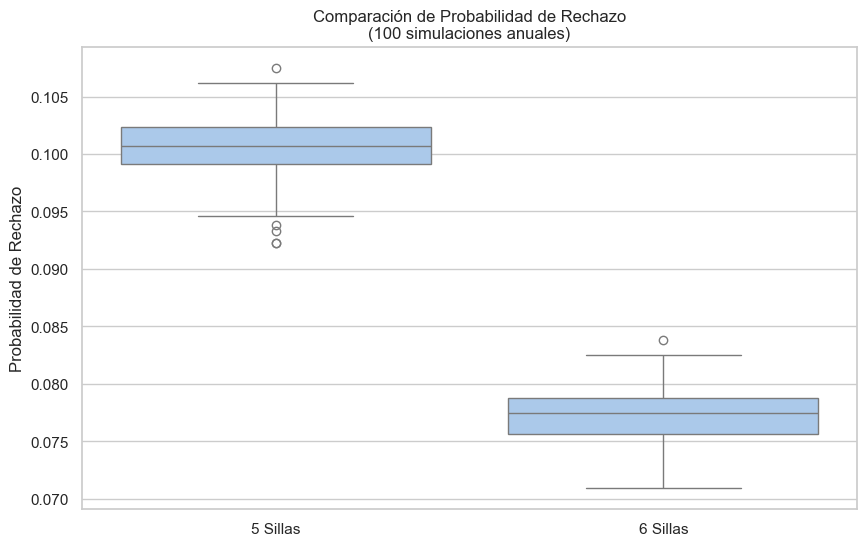

**p-value:** 0.000000

**Diferencia promedio:** 2.33%

✅ **Conclusión:** Diferencia estadísticamente significativa (p < 0.05)

In [54]:
def prueba_hipotesis_sillas(n_sim=100):
    display(Markdown("### 🧪 Prueba de Hipótesis: 5 vs 6 Sillas"))
    
    # Simular ambos escenarios
    resultados_5 = [simulacion_peluqueria(5)['P_rechazo'] for _ in range(n_sim)]
    resultados_6 = [simulacion_peluqueria(6)['P_rechazo'] for _ in range(n_sim)]
    
    # Test estadístico
    t_stat, p_val = stats.ttest_ind(resultados_5, resultados_6)
    
    # Visualización
    plt.figure(figsize=(10,6))
    sns.boxplot(x=['5 Sillas']*n_sim + ['6 Sillas']*n_sim,
                y=resultados_5 + resultados_6)
    plt.title('Comparación de Probabilidad de Rechazo\n(100 simulaciones anuales)')
    plt.ylabel('Probabilidad de Rechazo')
    plt.savefig('images/hipotesis_rechazo.png', dpi=300)
    plt.show()
    
    # Resultados
    display(Markdown(f"**p-value:** {p_val:.6f}"))
    display(Markdown(f"**Diferencia promedio:** {np.mean(resultados_5)-np.mean(resultados_6):.2%}"))
    
    if p_val < 0.05:
        display(Markdown("✅ **Conclusión:** Diferencia estadísticamente significativa (p < 0.05)"))
    else:
        display(Markdown("❌ **Conclusión:** No hay evidencia suficiente para rechazar H0"))

prueba_hipotesis_sillas()

### 📈 Sensibilidad a la Capacidad

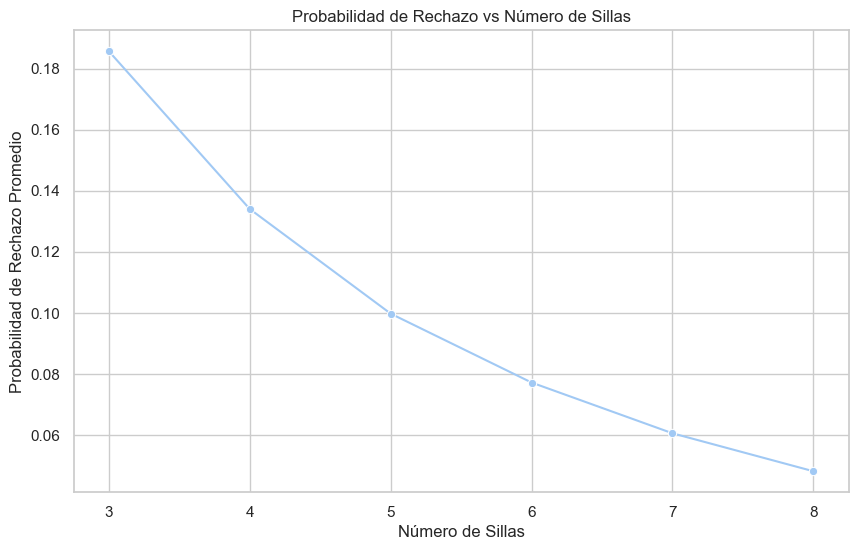

In [55]:
def analisis_sensibilidad():
    display(Markdown("### 📈 Sensibilidad a la Capacidad"))
    capacidades = range(3, 9)
    promedios = []
    
    for c in capacidades:
        simulaciones = [simulacion_peluqueria(c)['P_rechazo'] for _ in range(30)]
        promedios.append(np.mean(simulaciones))
    
    plt.figure(figsize=(10,6))
    sns.lineplot(x=capacidades, y=promedios, marker='o')
    plt.title('Probabilidad de Rechazo vs Número de Sillas')
    plt.xlabel('Número de Sillas')
    plt.ylabel('Probabilidad de Rechazo Promedio')
    plt.grid(True)
    plt.savefig('images/sensibilidad.png', dpi=300)
    plt.show()

analisis_sensibilidad()

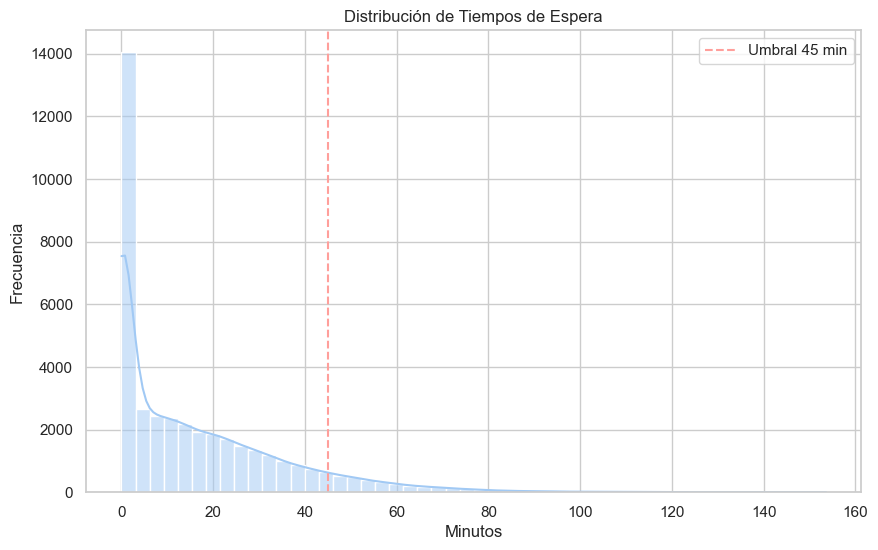

In [56]:
def visualizar_esperas():
    resultados = simulacion_peluqueria()
    esperas = resultados['tiempos_espera'] * 60  # Convertir a minutos
    
    plt.figure(figsize=(10,6))
    sns.histplot(esperas, bins=50, kde=True)
    plt.axvline(x=45, color='r', linestyle='--', label='Umbral 45 min')
    plt.title('Distribución de Tiempos de Espera')
    plt.xlabel('Minutos')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.savefig('images/distribucion_esperas.png', dpi=300)
    plt.show()

visualizar_esperas()